# Calculando el autocorrelograma para el IMAE de Costa Rica

*Material del curso EC4301 Macroeconometría*

Universidad de Costa Rica

**Profesor:  Randall Romero Aguilar**

Actualizado: 2025-Ago-8

Ejemplo numérico para ilustrar el uso del autocorrelograma y el autocorrelograma parcial.

In [1]:
from bccr import SW
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import os

figpath = "../figures/"
SAVEFIGS = False
EXPORTDATA = True

## Importamos los datos
La clase `ServicioWeb` permite obtener datos directamente del Banco Central de Costa Rica

Buscamos series que tenga "IMAE" en su DESCRIPCION, frecuencia mensual. Filtramos los resultados para ver solo las series en nivel, y dejamos solo aquellos que tengan la palabra "IMAE" en su descripción

In [2]:
imaes = SW.buscar(todos='IMAE', frecuencia='M')
imaes = imaes[imaes.Unidad == 'Nivel']
imaes[imaes.DESCRIPCION.str.contains('IMAE')]

,DESCRIPCION,Unidad,Medida,periodo
codigo,,,,


De esta lista, escogemos los indicadores <strike>35449 (serie original) y 35553 (tendencia-ciclo)</strike> (estas están discontinuadas, usarememos entonces las series 87703 y 87764, que de momentos no pueden encontrarse con bccr, pero sí descargarse). Descargamos los datos y cambiamos los nombres de las series.

In [3]:
imae = SW(Original=87703, Tendencia_ciclo=87764)

Graficamos las dos series para ver su dinamica.

<Axes: xlabel='fecha'>

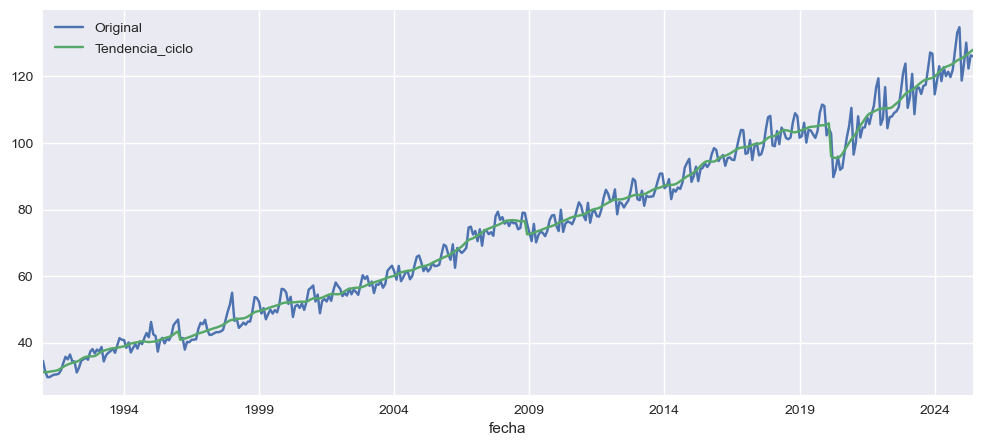

In [4]:
imae.plot(figsize=[12,5])

## Autocorrelograma

Obtenemos autocorrelogramas (48 rezagos, con intervalos de 95% de significancia (Bartlett)) para las series en nivel, primera diferencia, y diferencia estacional.

In [5]:
OPCIONES = dict(lags=48, alpha=0.05, title='', zero=False)
plot_acf = sm.graphics.tsa.plot_acf
plot_pacf = sm.graphics.tsa.plot_pacf
log_imae = np.log(imae)

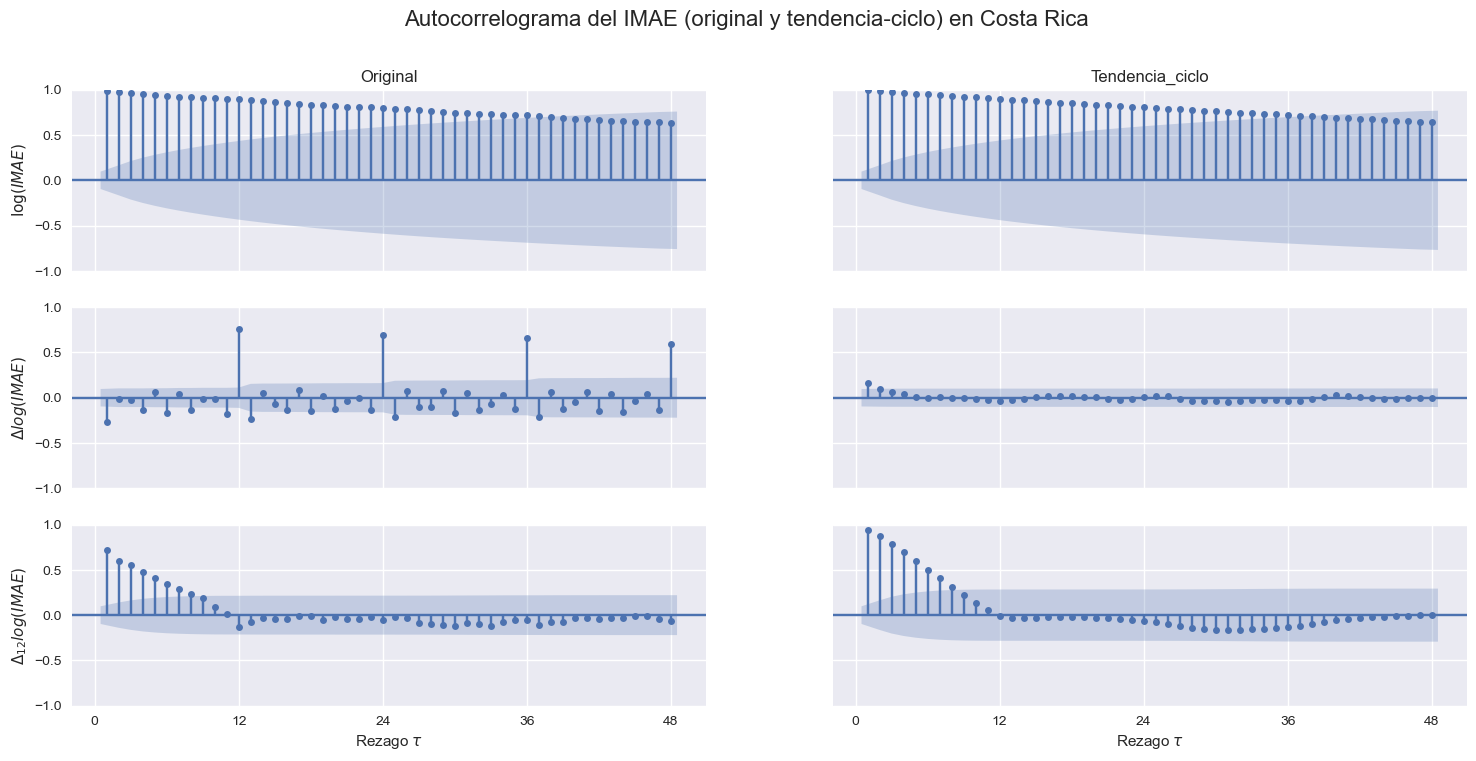

In [6]:
fig, axs = plt.subplots(3,2, figsize=[18,8], sharex=True, sharey=True)

for indic, ax in zip(imae, axs.T):
    plot_acf(log_imae[indic].dropna(), ax=ax[0], **OPCIONES);
    plot_acf(log_imae[indic].diff().dropna(), ax=ax[1], **OPCIONES);
    plot_acf(log_imae[indic].diff(12).dropna(), ax=ax[2], **OPCIONES);

for indic, ax in zip(imae, axs[0]):
    ax.set_title(indic)

for ax in axs[-1]:
    ax.set_xlabel(r'Rezago $\tau$')
    ax.set_xticks(np.arange(0,49,12));

axs[0,0].set_ylabel(r'$\log(IMAE)$')
axs[1,0].set_ylabel(r'$\Delta log(IMAE)$')
axs[2,0].set_ylabel(r'$\Delta_{12} log(IMAE)$')

fig.suptitle('Autocorrelograma del IMAE (original y tendencia-ciclo) en Costa Rica', size=16)

if SAVEFIGS:
    fig.savefig(figpath + 'IMAE-acf.png', bbox_inches='tight')    

## Autocorrelograma parcial

Repetimos el ejercicio, pero esta vez obtenemos autocorrelogramas parciales (48 rezagos, con intervalos de 95% de significancia) para las series en nivel, primera diferencia, y diferencia estacional.

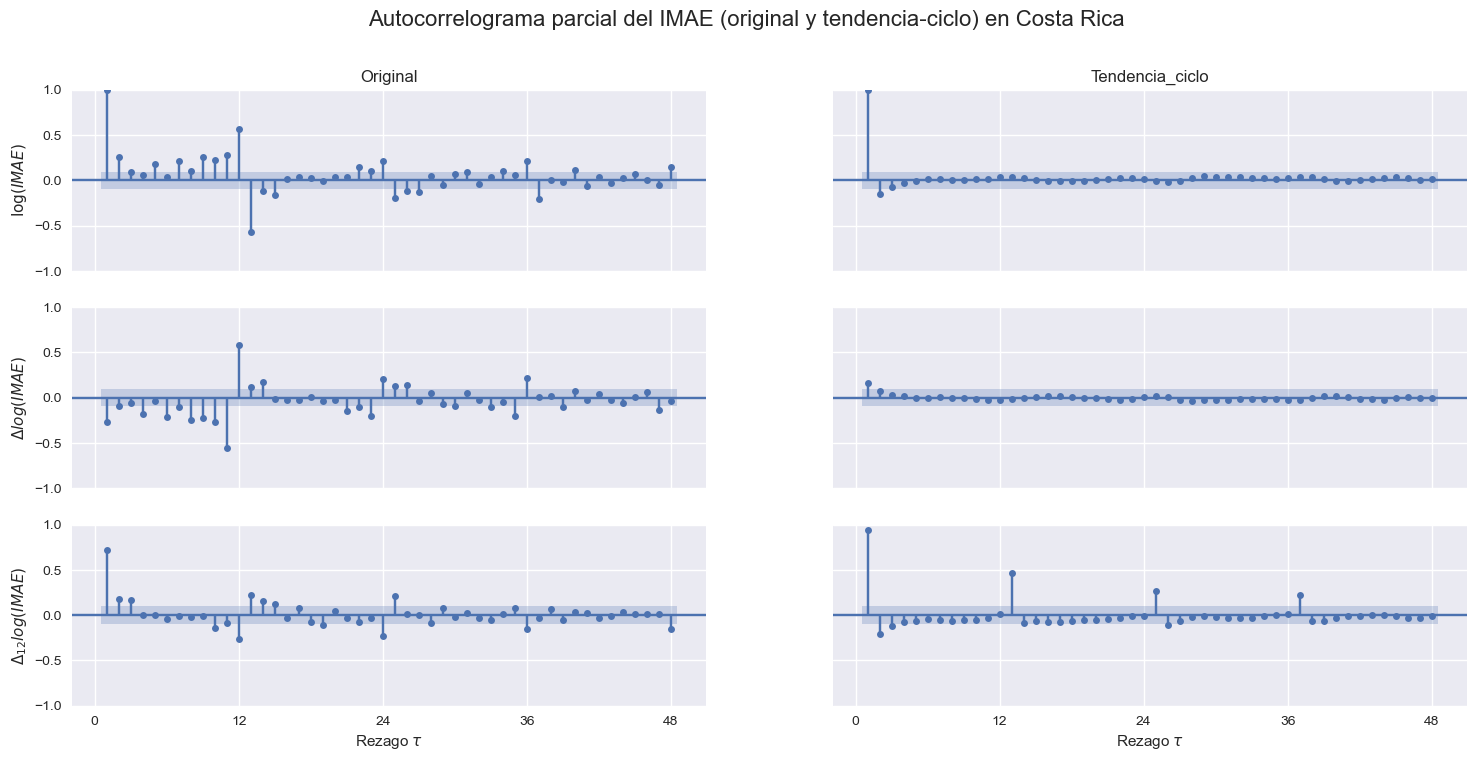

In [7]:
OPCIONES = dict(lags=48, alpha=0.05, title='', method='ols', zero=False)

fig, axs = plt.subplots(3,2, figsize=[18,8], sharex=True, sharey=True)

for indic, ax in zip(imae, axs.T):
    plot_pacf(log_imae[indic].dropna(), ax=ax[0], **OPCIONES);
    plot_pacf(log_imae[indic].diff().dropna(), ax=ax[1], **OPCIONES);
    plot_pacf(log_imae[indic].diff(12).dropna(), ax=ax[2], **OPCIONES);

for indic, ax in zip(imae, axs[0]):
    ax.set_title(indic)

for ax in axs[-1]:
    ax.set_xlabel(r'Rezago $\tau$')
    ax.set_xticks(np.arange(0,49,12));

axs[0,0].set_ylabel(r'$\log(IMAE)$')
axs[1,0].set_ylabel(r'$\Delta log(IMAE)$')
axs[2,0].set_ylabel(r'$\Delta_{12} log(IMAE)$')

fig.suptitle('Autocorrelograma parcial del IMAE (original y tendencia-ciclo) en Costa Rica', size=16)

if SAVEFIGS:
    fig.savefig(figpath + 'IMAE-pacf.png', bbox_inches='tight')    

## Pruebas de ruido blanco

¿Es es crecimiento mensual del IMAE tendencia-ciclo un proceso ruido blanco?

In [8]:
growth = log_imae['Tendencia_ciclo'].diff().dropna()
T = growth.size  # número de datos
M = 18   # máximo número de rezagos
rezagos = np.arange(1, M+1)
alpha = 0.05  # significancia de los test

Calculamos las autocovarianzas, a partir de un rezago

In [9]:
rho = sm.tsa.acf(growth, fft=True, nlags=M)[1:] 

Calculamos el estadístico de Box-Pierce, para todos los rezagos desde el 1 hasta el 7

\begin{equation}
Q^{*} = T\sum_{j=1}^{m}\hat{\rho}_j^2 \; \overset{\text{asy}}{\sim} \; \chi^2_{m-k}
\end{equation}

In [10]:
Qstar = T * (rho ** 2).cumsum()

Calculamos el estadístico de Ljung-Box

\begin{equation}
Q = T(T+2)\sum_{j=1}^{m}\frac{\hat{\rho}_j^2}{T-j} \; \overset{\text{asy}}{\sim} \; \chi^2_{m-k}
\end{equation}

In [11]:
Q = T * (T+2) * ((rho ** 2)/(T-rezagos)).cumsum()

Calculamos los valores críticos, tomando en cuenta que $k=0$ porque los datos que estamos usando no son residuos

In [12]:
vcrits = np.array([chi2(k).ppf(1-alpha) for k in rezagos])

Con carácter informativo nada más, calculamos la autocorrelación parcial

In [13]:
rhop = sm.tsa.pacf(growth, nlags=M, method='ols')[1:]

Juntamos todos los resultados en una tabla de resumen.

In [14]:
resumen = pd.DataFrame({'AC':rho, 'PAC': rhop, 'Box-Pierce':Qstar, 'Ljung-Box':Q, f'$\\chi^2(m-k)$': vcrits}, index=rezagos)
resumen.index.name = 'Rezagos'

resumen.round(3)

,AC,PAC,Box-Pierce,Ljung-Box,$\chi^2(m-k)$
Rezagos,,,,,
1,0.161,0.161,10.732,10.810,3.841
2,0.101,0.077,14.914,15.033,5.991
3,0.058,0.031,16.294,16.429,7.815
4,0.039,0.019,16.915,17.060,9.488
5,0.011,-0.005,16.967,17.113,11.070
6,0.001,-0.006,16.968,17.113,12.592
7,0.007,0.005,16.990,17.136,14.067
8,0.002,-0.001,16.991,17.137,15.507
9,-0.005,-0.006,17.000,17.146,16.919


### Exportar datos
Finalmente, exportamos los datos para poder replicar este ejercicio con otros programas (Stata, EViews, R).

In [15]:
if EXPORTDATA:
    log_imae.to_csv('data/log_imae.csv')
    log_imae.index = log_imae.index.to_timestamp()
    log_imae.reset_index().to_stata(
        'data/log_imae.dta', 
        variable_labels={'Original':'IMAE Original SW(87703)', 'Tendencia_ciclo':'IMAE Tendencia-Ciclo SW(87764)'},
        data_label="IMAE Costa Rica, read with bccr.SW using correlogram.ipynb",
        convert_dates={'fecha':'tm'}, 
        version=118, 
        write_index=False)
